# Assignment 4: Fourth Research/Programming Assignment

### Jessy Chang

In [1]:
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

# Common imports
import numpy as np
import pandas as pd
import os
import warnings
import time
import seaborn as sns
import json
from itertools import chain


# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt


# For model development
import tensorflow as tf
from tensorflow import keras
from keras.datasets import cifar10, imdb
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Embedding
from keras.layers import LSTM
from keras.layers import Conv2D, MaxPooling2D, Conv1D, MaxPooling1D
from keras import optimizers

from sklearn.model_selection import train_test_split
from sklearn import metrics


# Ignore warnings
warnings.filterwarnings("ignore")

# Creates folder for program outputs
if not os.path.exists("Program Outputs"):
    os.makedirs("Program Outputs")
    
# # Set dataframe display & print option
# pd.set_option('display.max_columns', 500)

# Set random seed for reproducible results 
np.random.seed(seed = 3333)
tf.set_random_seed(seed = 3333)
RANDOM_SEED = 3333

# Set up base class for callbacks to monitor training
# and for early stopping during training
tf.keras.callbacks.Callback()

Using TensorFlow backend.


In [2]:
print('\nTensorFlow version: ', tf.__version__)

# with TensorFlow 2.0+, keras may be accessed as tf.keras
print('Keras version: ', tf.keras.__version__)


TensorFlow version:  1.15.0
Keras version:  2.2.4-tf


## Model Development

In [3]:
def model_results(model, experiment, history, execution_time):    
    file = str('Program Outputs/' + experiment +"_performance.txt")
    with open(file,'w') as fh:
        # Pass the file handle in as a lambda function to make it callable
        model.summary(print_fn=lambda x: fh.write(x + '\n'))

    # Evaluate fitted model on the training set
    train_loss, train_acc = model.evaluate(x_train, y_train, verbose = 3)

    # Evaluate the fitted model on the hold-out test set
    test_loss, test_acc = model.evaluate(x_test, y_test, verbose = 3)
    
    # Examine the predicted values within a precision/recall framework
    test_preds = np.argmax(model.predict(x_test), axis = 1)
    
    pr_results = str('\nProcessing time for training (seconds): %f' % execution_time +
                     '\nTraining set accuracy: {:6.4f}'.format(np.round(train_acc, decimals = 4)) +
                     '\nTraining set loss: {:6.4f}'.format(np.round(train_loss, decimals = 4)) +
                     '\nHold-out test set accuracy: {:6.4f}'.format(np.round(test_acc, decimals = 4)) +
                     '\nHold-out test set loss: {:6.4f}'.format(np.round(test_loss, decimals = 4)))
            
    print(pr_results)

            
    file = str('Program Outputs/' + experiment +"_performance.txt")
    with open(file, "a") as file:
        file.write(str(pr_results))
    
    results = {'history': history,
               'process_time': execution_time,
               'train_loss': train_loss,
               'train_acc': train_acc,
               'test_loss': test_loss,
               'test_acc': test_acc,
               'test_pred': test_preds}
    
    return results

In [4]:
def model_results2(model, experiment, history, execution_time):    
    file = str('Program Outputs/' + experiment +"_performance.txt")
    with open(file,'w') as fh:
        # Pass the file handle in as a lambda function to make it callable
        model.summary(print_fn=lambda x: fh.write(x + '\n'))

    # Evaluate fitted model on the training set
    train_loss, train_acc = model.evaluate(x_train, y_train, verbose = 3)

    # Evaluate the fitted model on the hold-out test set
    test_loss, test_acc = model.evaluate(x_test, y_test, verbose = 3)
    
    # Examine the predicted values within a precision/recall framework
    test_preds = np.where(model.predict(x_test)<0.5,0,1)
    
    pr_results = str('\nProcessing time for training (seconds): %f' % execution_time +
                     '\nTraining set accuracy: {:6.4f}'.format(np.round(train_acc, decimals = 4)) +
                     '\nTraining set loss: {:6.4f}'.format(np.round(train_loss, decimals = 4)) +
                     '\nHold-out test set accuracy: {:6.4f}'.format(np.round(test_acc, decimals = 4)) +
                     '\nHold-out test set loss: {:6.4f}'.format(np.round(test_loss, decimals = 4)))
            
    print(pr_results)

            
    file = str('Program Outputs/' + experiment +"_performance.txt")
    with open(file, "a") as file:
        file.write(str(pr_results))
    
    results = {'history': history,
               'process_time': execution_time,
               'train_loss': train_loss,
               'train_acc': train_acc,
               'test_loss': test_loss,
               'test_acc': test_acc,
               'test_pred': test_preds}
    
    return results

In [5]:
# The training process may be evaluated by comparing training and
# dev (validation) set performance. We use "dev" to indicate
# that these data are used in evaluating various hyperparameter
# settings. We do not test alternative hyperparameters here,
# but in other programs there will be much hyperparameter testing.
def plot_history(history, experiment):
    accuracy = history.history['acc']
    val_accuracy = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epoch_number = range(1, len(accuracy) + 1)
    plt.style.use('ggplot') # Grammar of Graphics plots
    plt.figure(figsize=(20, 10))
    plt.subplot(1, 2, 1)
    plt.plot(epoch_number, accuracy, 'b', label='Training')
    plt.plot(epoch_number, val_accuracy, 'r', label='Dev')
    plt.title('Training and Dev Set Accuracy')
    plt.xlabel('Epoch Number')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(epoch_number, loss, 'b', label='Training')
    plt.plot(epoch_number, val_loss, 'r', label='Dev')
    plt.title('Training and Dev Set Loss')
    plt.xlabel('Epoch Number')
    plt.ylabel('Loss')
    plt.legend()
    plt.savefig('Program Outputs/'+ experiment +'_fig_training_process.pdf', 
        papertype = 'letter', orientation ='landscape')

In [6]:
# Plot confusion matrix to external file
def plot_confusion(test_preds, experiment):
    cm_data = metrics.confusion_matrix(y_test, test_preds)
    plt.figure()
    selected_cmap = sns.cubehelix_palette(light=1, as_cmap=True)
    sns_plot = sns.heatmap(cm_data, annot=True, fmt="d", \
                           cmap = selected_cmap, linewidths = 0.5, cbar = False)
    sns_plot.set_yticklabels(sns_plot.get_yticklabels(), rotation = 0)
    plt.title('Confusion Matrix')
    plt.ylabel('True Image')
    plt.xlabel('Predicted Image')
    plt.savefig('Program Outputs/'+ experiment +'_fig_confusion_matrix.pdf', 
        papertype = 'letter', orientation ='landscape')


## Experiment #1
### CIFAR-10 Dataset
* Model 1A - Using Python
* Model 1B - Using R

In [27]:
# Import CIFAR10 small image classification dataset from Keras
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# Split data to train & validation
# x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=10000, random_state=RANDOM_SEED)

In [28]:
# Create dictionary to map labels as words
label_w = {'0':'Airplane', 
           '1':'Automobile',
           '2':'Bird',
           '3':'Cat',
           '4':'Deer',
           '5':'Dog', 
           '6':'Frog', 
           '7':'Horse',
           '8':'Ship',
           '9':'Truck'}


Train Shape: X = (50000, 32, 32, 3), y = (50000, 1)
Validation Shape: X = (10000, 32, 32, 3), y = (10000, 1)
Test Shape: X = (10000, 32, 32, 3), y = (10000, 1)


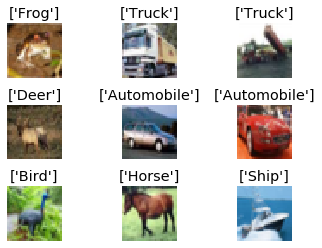

In [29]:
# Summarize loaded dataset
print('Train Shape: X = %s, y = %s' % (x_train.shape, y_train.shape))
print('Validation Shape: X = %s, y = %s' % (x_val.shape, y_val.shape))
print('Test Shape: X = %s, y = %s' % (x_test.shape, y_test.shape))

# Plot first few images
for i in range(9):
    # define subplot
    plt.subplot(330 + 1 + i)
    plt.subplots_adjust(wspace=0.1, hspace=0.5)
    plt.axis('off')
    # plot raw pixel data
    plt.imshow(x_train[i])
    # show label in plot
    plt.title(list(map(label_w.get, y_train[i].astype(str))))

# Route plot to external pdf file
plt.savefig('Program Outputs/cifar10_sample_image.pdf', 
            bbox_inches = 'tight', dpi=None, facecolor='w', 
            edgecolor='b', orientation='portrait', papertype=None, 
            format=None, transparent=True, pad_inches=0.25, frameon=None)

### Model 1A

In [30]:
# Normalize the data
# the pixel values are in the range of 0 to 255 for each of the red, green and blue channels
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

In [31]:
# Set model to run for epochs unless early stopping rule is met
# see documentation at https://keras.io/callbacks/
# note that 100 is many more epochs than needed for MNIST
# but we employ early stopping to shorten the training time
max_epochs = 100  
earlystop_callback = \
    tf.keras.callbacks.EarlyStopping(monitor='val_acc',\
    min_delta=0.01, patience=5, verbose=0, mode='auto',\
    baseline=None, restore_best_weights=False)


In [32]:
experiment = 'model1A'

# Define a model with Keras
model1A = Sequential()
model1A.add(Conv2D(32, (3, 3), padding='same',
                   input_shape=x_train.shape[1:]))
model1A.add(Activation('relu'))
model1A.add(Conv2D(32, (3, 3)))
model1A.add(Activation('relu'))
model1A.add(MaxPooling2D(pool_size=(2, 2)))
model1A.add(Dropout(0.25))

model1A.add(Conv2D(64, (3, 3), padding='same'))
model1A.add(Activation('relu'))
model1A.add(Conv2D(64, (3, 3)))
model1A.add(Activation('relu'))
model1A.add(MaxPooling2D(pool_size=(2, 2)))
model1A.add(Dropout(0.25))

model1A.add(Flatten())
model1A.add(Dense(512))
model1A.add(Activation('relu'))
model1A.add(Dropout(0.5))
model1A.add(Dense(10))
model1A.add(Activation('softmax'))


print('Structure of Neural Network')
print(model1A.summary())

Structure of Neural Network
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
activation_12 (Activation)   (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 30, 30, 32)        9248      
_________________________________________________________________
activation_13 (Activation)   (None, 30, 30, 32)        0         
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 15, 15, 32)        0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 15, 15, 64) 

In [33]:
# Define settings for training the model
# Compile model
model1A.compile(optimizer='adam',
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])

    
print('\nEpoch-by-Epoch Training Process')
begin_time = time.time()
history1A = model1A.fit(x_train, y_train,
                        epochs = max_epochs, shuffle = False,
                        validation_split = 0.2,
                        verbose = 2,
                        callbacks = [earlystop_callback])
execution_time1A = time.time() - begin_time


Epoch-by-Epoch Training Process
Train on 40000 samples, validate on 10000 samples
Epoch 1/100
 - 138s - loss: 1.5827 - acc: 0.4207 - val_loss: 1.2453 - val_acc: 0.5665
Epoch 2/100
 - 138s - loss: 1.1743 - acc: 0.5808 - val_loss: 1.0327 - val_acc: 0.6476
Epoch 3/100
 - 132s - loss: 0.9985 - acc: 0.6460 - val_loss: 0.8998 - val_acc: 0.6883
Epoch 4/100
 - 155s - loss: 0.9061 - acc: 0.6803 - val_loss: 0.8573 - val_acc: 0.7038
Epoch 5/100
 - 133s - loss: 0.8383 - acc: 0.7042 - val_loss: 0.8068 - val_acc: 0.7231
Epoch 6/100
 - 154s - loss: 0.7821 - acc: 0.7250 - val_loss: 0.7292 - val_acc: 0.7467
Epoch 7/100
 - 136s - loss: 0.7424 - acc: 0.7370 - val_loss: 0.7609 - val_acc: 0.7365
Epoch 8/100
 - 145s - loss: 0.7019 - acc: 0.7515 - val_loss: 0.7343 - val_acc: 0.7474
Epoch 9/100
 - 153s - loss: 0.6756 - acc: 0.7608 - val_loss: 0.7157 - val_acc: 0.7554
Epoch 10/100
 - 140s - loss: 0.6472 - acc: 0.7723 - val_loss: 0.6976 - val_acc: 0.7660
Epoch 11/100
 - 176s - loss: 0.6163 - acc: 0.7837 - val_

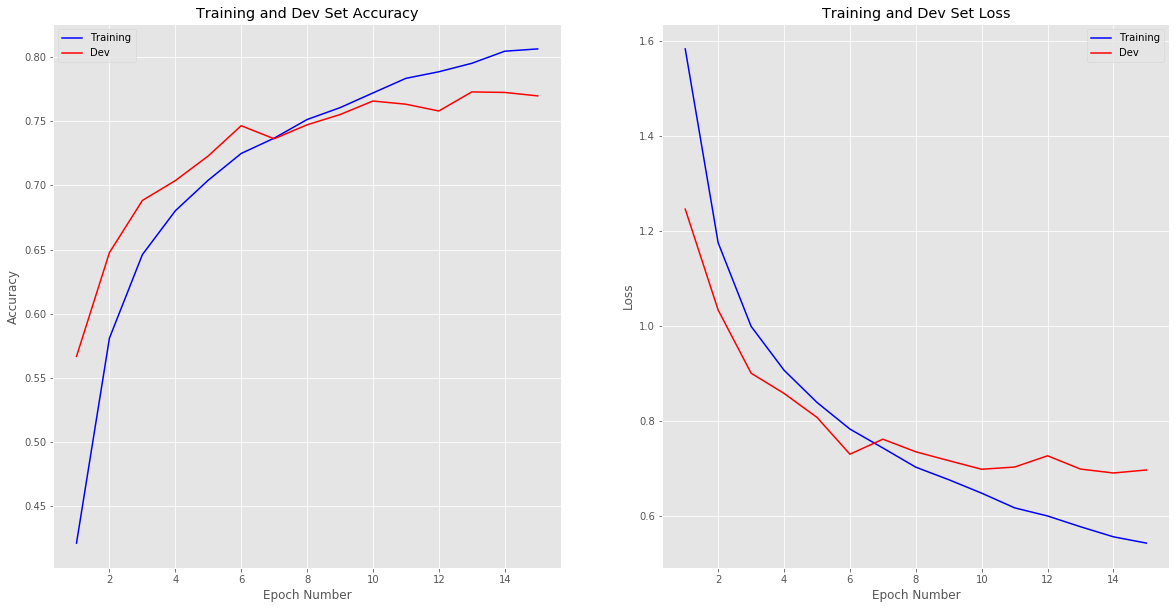

In [37]:
# Plot training history
plot_history(history1A, experiment)

In [38]:
# Print and store model results
result1A = model_results(model1A, experiment, history1A, execution_time1A)


Processing time for training (seconds): 2219.973824
Training set accuracy: 0.8878
Training set loss: 0.3676
Hold-out test set accuracy: 0.7660
Hold-out test set loss: 0.7110


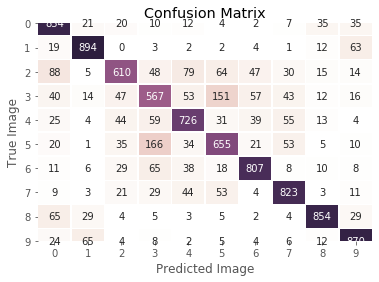

In [46]:
# Plot confusion matrix 
plot_confusion(result1A['test_pred'], experiment)

## Experiment #2
### IMDB Dataset
* Model 2A - Using Python
* Model 2B - Using R

In [3]:
# save np.load
np_load_old = np.load
# modify the default parameters of np.load
np.load = lambda *a,**k: np_load_old(*a, allow_pickle=True, **k)

# Import IMDB Movie reviews sentiment classification dataset from Keras
(x_train, y_train), (x_test, y_test) = imdb.load_data(path="imdb.npz",
                                                      num_words=None,
                                                      skip_top=0,
                                                      maxlen=None,
                                                      seed=113,
                                                      start_char=1,
                                                      oov_char=2,
                                                      index_from=3)

# restore np.load for future normal usage
np.load = np_load_old

In [4]:
# Summarize loaded dataset
print('Train Shape: X = %s, y = %s' % (x_train.shape, y_train.shape))
print('Test Shape: X = %s, y = %s' % (x_test.shape, y_test.shape))

# Summarize number of classes
print("Classes: ")
print(np.unique(y_train))
# Summarize number of words
print("Number of words: ")
print(len(np.unique(np.hstack(x_train))))

Train Shape: X = (25000,), y = (25000,)
Test Shape: X = (25000,), y = (25000,)
Classes: 
[0 1]
Number of words: 
88585


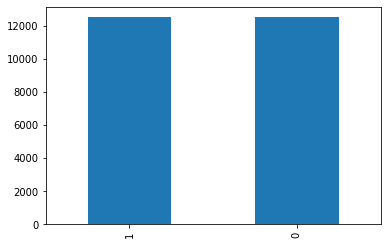

In [5]:
# Plot class frequency
pd.DataFrame(y_train)[0].value_counts().plot('bar')

# Route plot to external pdf file
plt.savefig('Program Outputs/review_class_frequency.pdf', 
            bbox_inches = 'tight', dpi=None, facecolor='w', 
            edgecolor='b', orientation='portrait', papertype=None, 
            format=None, transparent=True, pad_inches=0.25, frameon=None)

Review length: 
Mean 238.71 words (176.493674)
Max 2494 words
Min 11 words


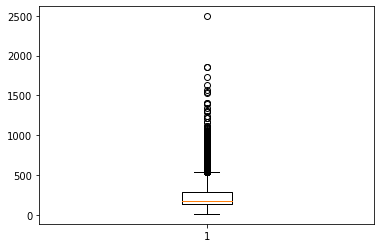

In [6]:
# Summarize review length
print("Review length: ")
result = [len(x) for x in x_train]
print("Mean %.2f words (%f)" % (np.mean(result), np.std(result)))
print("Max %.0f words" % np.max(result))
print("Min %.0f words" % np.min(result))

# Plot review length
plt.boxplot(result)

# Route plot to external pdf file
plt.savefig('Program Outputs/review_number_of_words_boxplot.pdf', 
            bbox_inches = 'tight', dpi=None, facecolor='w', 
            edgecolor='b', orientation='portrait', papertype=None, 
            format=None, transparent=True, pad_inches=0.25, frameon=None)

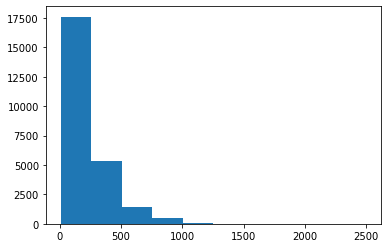

In [7]:
plt.hist(result)

# Route plot to external pdf file
plt.savefig('Program Outputs/review_number_of_words_histogram.pdf', 
            bbox_inches = 'tight', dpi=None, facecolor='w', 
            edgecolor='b', orientation='portrait', papertype=None, 
            format=None, transparent=True, pad_inches=0.25, frameon=None)

In [8]:
# Define the topics
# Source: https://github.com/keras-team/keras/issues/12072#issuecomment-458154097
topics = ['negative','positive']

# Obtain 3 texts randomly
for i in np.random.randint(0, len(x_train), 3):
    INDEX_FROM = 3   # word index offset
    word_to_id = imdb.get_word_index()
    word_to_id = {k:(v+INDEX_FROM) for k,v in word_to_id.items()}
    word_to_id["<PAD>"] = 0
    word_to_id["<START>"] = 1
    word_to_id["<UNK>"] = 2
#     word_to_id["<UNUSED>"] = 3
    id_to_word = {value:key for key,value in word_to_id.items()}
    print('=================================================')
    print(f'Sample = {i} | Sentiment = {topics[y_train[i]]} ({y_train[i]})')
    print('=================================================')
    print(' '.join(id_to_word[id] for id in x_train[i] ))


Sample = 5326 | Sentiment = positive (1)
<START> i realize this review will get me bashed by the expert film critics patrolling this site but i will defend this film br br the dentist is actually a really good film the acting isn't always top notch but the thrills are good and the story's good plus you see linda hoffman's boobies not that i'm an expert in this field but the direction seems good and the plot makes sense corbin makes a great creepy dentist it does to dentists what jaws does to sharks ish it obviously had a fairly limited budget but they did well with it what they could and developed the characters well those that count br br the end
Sample = 100 | Sentiment = negative (0)
<START> i am a great fan of david lynch and have everything that he's made on dvd except for hotel room the 2 hour twin peaks movie so when i found out about this i immediately grabbed it and and what is this it's a bunch of crudely drawn black and white cartoons that are loud and foul mouthed and unfun

In [9]:
# Print the top 100 used words
top_words = []
for i in range(4,104):
    top_words.append(id_to_word.get(i))

print('Top 100 words:\n')
print(top_words)

Top 100 words:

['the', 'and', 'a', 'of', 'to', 'is', 'br', 'in', 'it', 'i', 'this', 'that', 'was', 'as', 'for', 'with', 'movie', 'but', 'film', 'on', 'not', 'you', 'are', 'his', 'have', 'he', 'be', 'one', 'all', 'at', 'by', 'an', 'they', 'who', 'so', 'from', 'like', 'her', 'or', 'just', 'about', "it's", 'out', 'has', 'if', 'some', 'there', 'what', 'good', 'more', 'when', 'very', 'up', 'no', 'time', 'she', 'even', 'my', 'would', 'which', 'only', 'story', 'really', 'see', 'their', 'had', 'can', 'were', 'me', 'well', 'than', 'we', 'much', 'been', 'bad', 'get', 'will', 'do', 'also', 'into', 'people', 'other', 'first', 'great', 'because', 'how', 'him', 'most', "don't", 'made', 'its', 'then', 'way', 'make', 'them', 'too', 'could', 'any', 'movies', 'after']


### Model 2A

In [7]:
# Embedding
max_features = 20000
maxlen = 250
embedding_size = 128

# Convolution
kernel_size = 5
filters = 64
pool_size = 4

# LSTM
lstm_output_size = 70

# Training
batch_size = 30


In [8]:
# save np.load
np_load_old = np.load
# modify the default parameters of np.load
np.load = lambda *a,**k: np_load_old(*a, allow_pickle=True, **k)

# Import IMDB Movie reviews sentiment classification dataset from Keras
(x_train, y_train), (x_test, y_test) = imdb.load_data(path="imdb.npz",
                                                      num_words=max_features,
                                                      index_from=3)

# restore np.load for future normal usage
np.load = np_load_old

In [9]:
# Set model to run for epochs unless early stopping rule is met
# see documentation at https://keras.io/callbacks/
# note that 100 is many more epochs than needed for the data
# but we employ early stopping to shorten the training time
max_epochs = 100  
earlystop_callback = \
    tf.keras.callbacks.EarlyStopping(monitor='val_acc',\
    min_delta=0.01, patience=5, verbose=0, mode='auto',\
    baseline=None, restore_best_weights=False)


In [10]:
print('Pad sequences (samples x time)')
x_train = sequence.pad_sequences(x_train, maxlen=maxlen)
x_test = sequence.pad_sequences(x_test, maxlen=maxlen)
print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)

Pad sequences (samples x time)
x_train shape: (25000, 250)
x_test shape: (25000, 250)


In [12]:
experiment = 'model2A'

# Build model
model2A = Sequential()
model2A.add(Embedding(max_features, embedding_size, input_length=maxlen))
model2A.add(Dropout(0.25))
model2A.add(Conv1D(filters,
                   kernel_size,
                   padding='valid',
                   activation='relu',
                   strides=1))
model2A.add(MaxPooling1D(pool_size=pool_size))
model2A.add(LSTM(lstm_output_size))
model2A.add(Dense(1))
model2A.add(Activation('sigmoid'))

print('Structure of Neural Network')
print(model2A.summary())

Structure of Neural Network
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 250, 128)          2560000   
_________________________________________________________________
dropout_2 (Dropout)          (None, 250, 128)          0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 246, 64)           41024     
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 61, 64)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 70)                37800     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 71        
_________________________________________________________________
activation_2 (Activation)    (None, 1)          

In [14]:
# Define settings for training the model
# Compile model
model2A.compile(loss='binary_crossentropy',
                optimizer='adam',
                metrics=['accuracy'])


print('\nEpoch-by-Epoch Training Process')
begin_time = time.time()
history2A = model2A.fit(x_train, y_train,
                        epochs=max_epochs,
                        validation_split = 0.2,
                        verbose = 2,
                        callbacks = [earlystop_callback])

execution_time2A = time.time() - begin_time



Epoch-by-Epoch Training Process
Train on 20000 samples, validate on 5000 samples
Epoch 1/100
 - 202s - loss: 0.3751 - acc: 0.8288 - val_loss: 0.2769 - val_acc: 0.8916
Epoch 2/100
 - 197s - loss: 0.1708 - acc: 0.9384 - val_loss: 0.2958 - val_acc: 0.8878
Epoch 3/100
 - 212s - loss: 0.0859 - acc: 0.9723 - val_loss: 0.3759 - val_acc: 0.8774
Epoch 4/100
 - 202s - loss: 0.0430 - acc: 0.9872 - val_loss: 0.4669 - val_acc: 0.8722
Epoch 5/100
 - 203s - loss: 0.0320 - acc: 0.9895 - val_loss: 0.5260 - val_acc: 0.8684
Epoch 6/100
 - 211s - loss: 0.0230 - acc: 0.9931 - val_loss: 0.5500 - val_acc: 0.8688


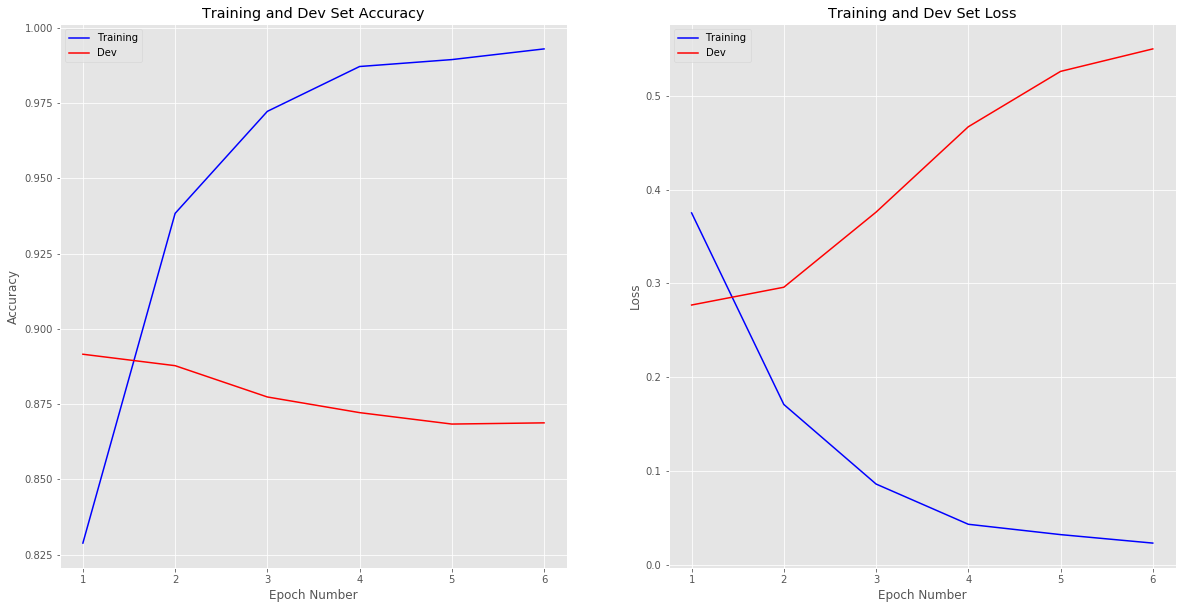

In [15]:
# Plot training history
plot_history(history2A, experiment)

In [16]:
# Print and store model results
result2A = model_results2(model2A, experiment, history2A, execution_time2A)


Processing time for training (seconds): 1227.013848
Training set accuracy: 0.9726
Training set loss: 0.1159
Hold-out test set accuracy: 0.8479
Hold-out test set loss: 0.6466


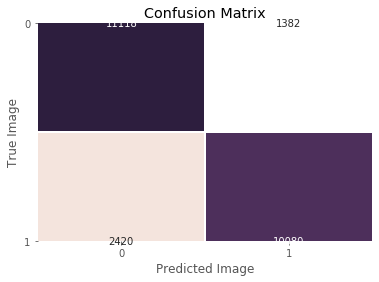

In [17]:
# Plot confusion matrix 
plot_confusion(result2A['test_pred'], experiment)

In [21]:
np.version.version

'1.17.2'